# Importing Libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage

# Reading image

(-0.5, 1079.5, 854.5, -0.5)

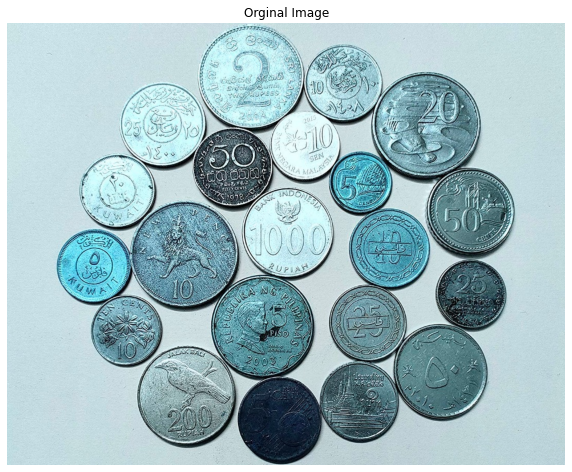

In [15]:
img = cv2.imread('coin_img.jpeg')

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('Orginal Image')
plt.axis('off')

# Preprocessing

Text(0.5, 1.0, 'Histogram')

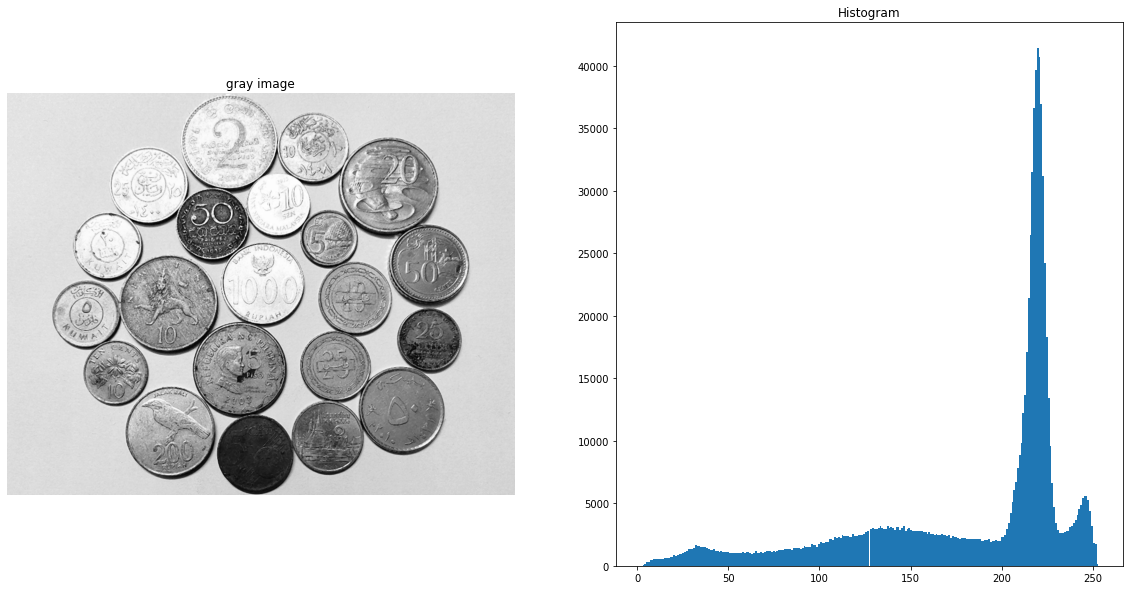

In [16]:
# Smoothing image with median filter blurring
img_blur = cv2.medianBlur(img, 3)

# Converting image to gray scale
gray_image = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)

# Plotting the image and its histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plotting the original image.
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('gray image')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(gray_image.ravel(), bins=255)
ax[1].set_title('Histogram')

As we can see the biggest peak in the histogram, corresponds to the background pixel value distribution.

So, we are going to suppress this peak by multi thresholding between the range of, approximately, 205 and 230.

# Thresholding

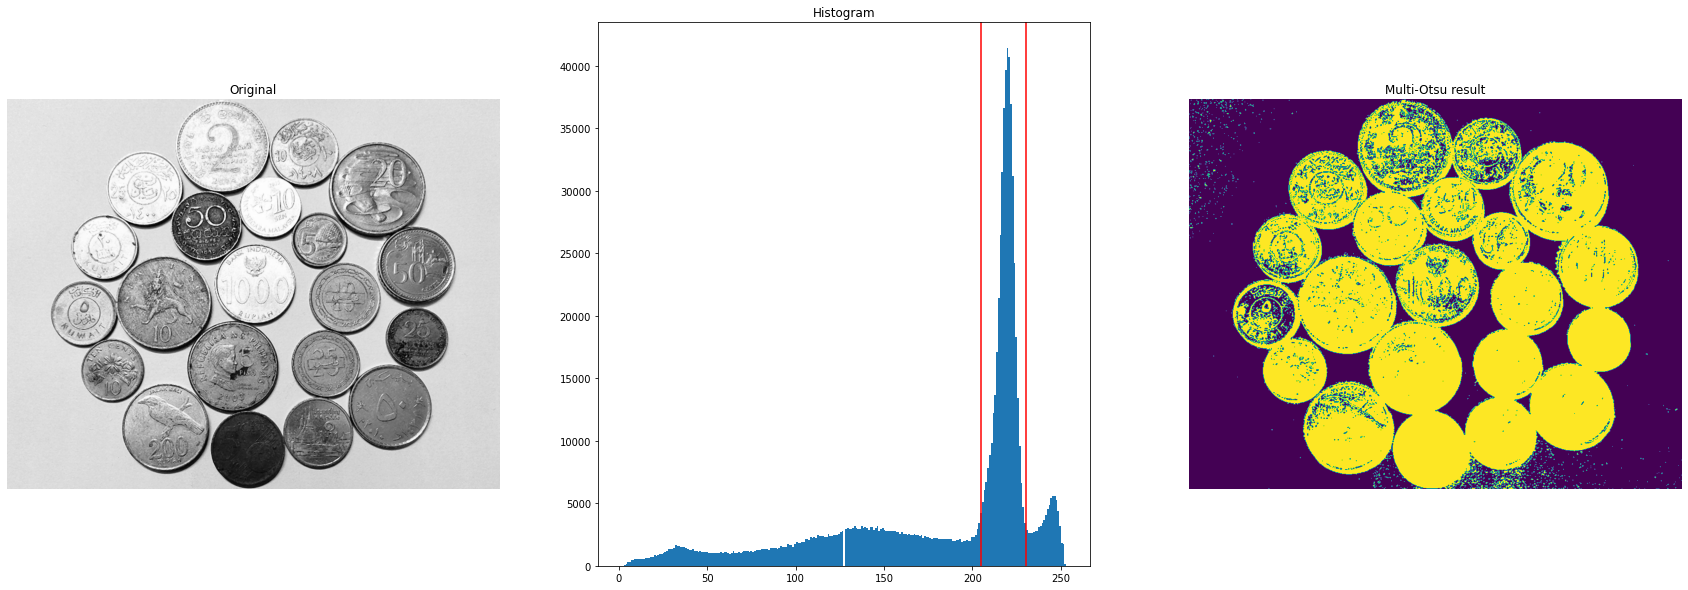

In [17]:
# Applying multi thresholding, generating
# three classes.
thresholds = np.array([205, 230])

# Using the threshold values, we generate the three regions.
regions = np.digitize(gray_image, bins=thresholds)
regions = np.where(regions==1, 0, 1)
regions = (regions*255).astype('uint8')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

# Plotting the original image.
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds.
ax[1].hist(gray_image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the multi thresholding result.
ax[2].imshow(regions)
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()

now, we have our binary image of the coins. but the image is noisy. some of the noisy pixels are inside the coins' border. and others are out of the site where the coins are gathered.

1. We are going to fill holes inside the coins gathering and then get rid of the noise out of the site by making a mask.

2. Then we will use the closing morphological operation to fill the coins and smooth the binary image.

In [18]:
def FillHole(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    len_contour = len(contours)
    contour_list = []
    for i in range(len_contour):
        drawing = np.zeros_like(mask, np.uint8)  # create a black image
        img_contour = cv2.drawContours(drawing, contours, i, (255, 255, 255), -1)
        contour_list.append(img_contour)

    out = sum(contour_list)
    return out

fill_holes = FillHole(regions)

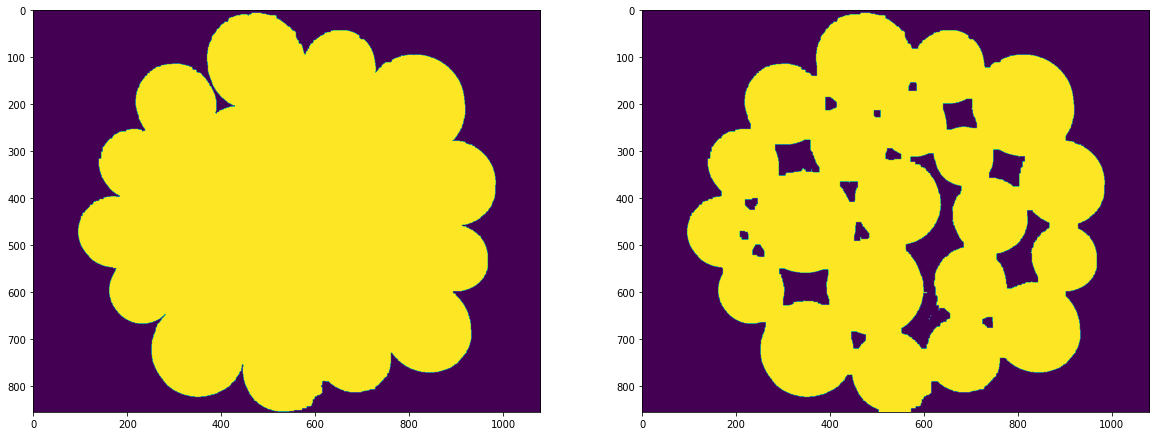

In [19]:
kernel = np.ones((3,3),np.uint8)

opening = cv2.morphologyEx(fill_holes, cv2.MORPH_OPEN, kernel, iterations=5)
opening = opening > 0
regions = opening*regions
closing = cv2.morphologyEx(regions, cv2.MORPH_CLOSE, kernel, iterations=5)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(opening)
plt.subplot(122)
plt.imshow(closing)

Now we have our clean binary image of coins!

# Coin Detection (Using Watershed Algorithm)

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result. This is the "philosophy" behind the watershed. You can visit the CMM webpage on watershed to understand it with the help of some animations.

But this approach gives you oversegmented result due to noise or any other irregularities in the image. So OpenCV implemented a marker-based watershed algorithm where you specify which are all valley points are to be merged and which are not. It is an interactive image segmentation. What we do is to give different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1. 

Source: https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

(-0.5, 1079.5, 854.5, -0.5)

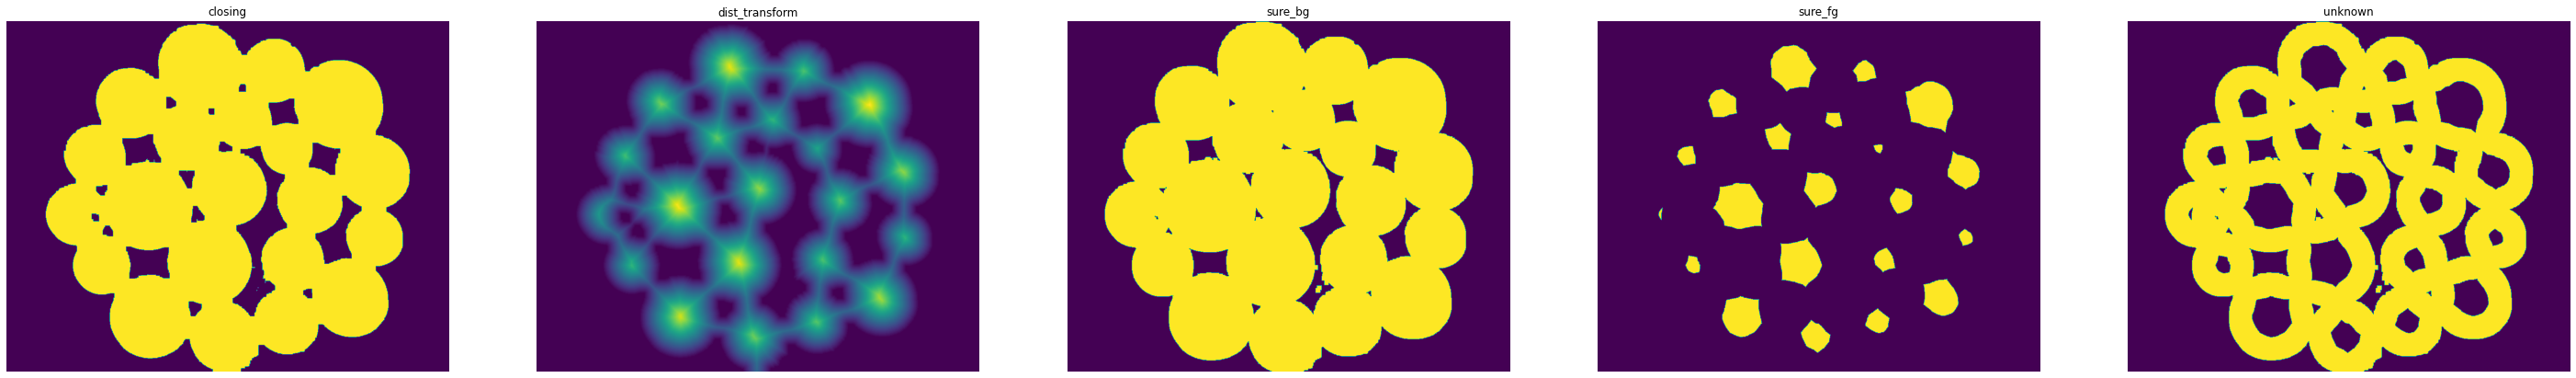

In [20]:
# sure background area
sure_bg = cv2.dilate(closing, kernel, iterations=5)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50, 10))

# Plotting the closing image.
ax[0].imshow(closing)
ax[0].set_title('closing')
ax[0].axis('off')

# Plotting the distnace tranform result.
ax[1].imshow(dist_transform)
ax[1].set_title('dist_transform')
ax[1].axis('off')

# Plotting the background image.
ax[2].imshow(sure_bg)
ax[2].set_title('sure_bg')
ax[2].axis('off')

# Plotting the foreground image.
ax[3].imshow(sure_fg)
ax[3].set_title('sure_fg')
ax[3].axis('off')

# Plotting the unknown particles image.
ax[4].imshow(unknown)
ax[4].set_title('unknown')
ax[4].axis('off')

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


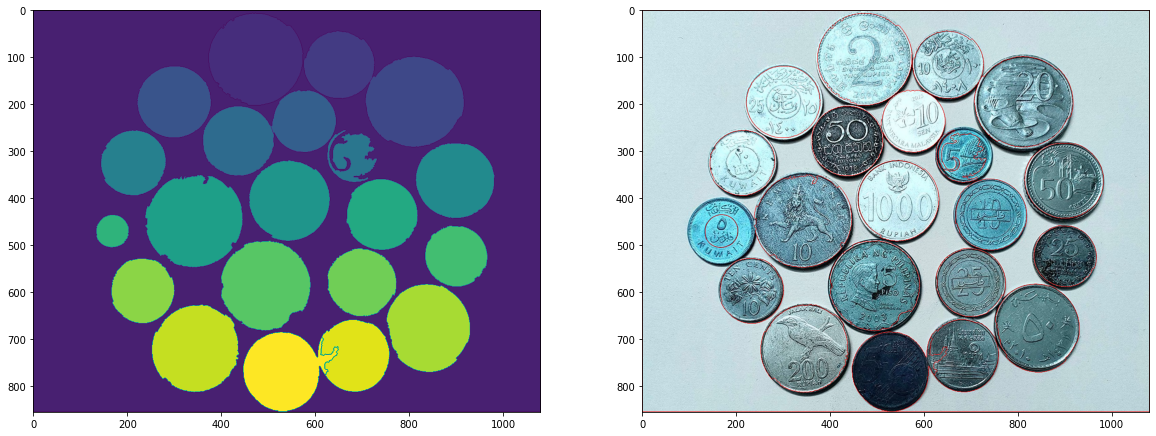

In [21]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# apply watershed algorithm
markers = cv2.watershed(img, markers)

# the -1 label is for the border of the coins
# we are going to apply it to the orginal image
img[markers == -1] = [255,0,0]

# printig out the unique values of markers
print(np.unique(markers))

plt.figure(figsize=(20, 10))
# markers
plt.subplot(121)
plt.imshow(markers)

# image with the borders
plt.subplot(122)
plt.imshow(img)

finding the mass center of each separated area corresponds to each coin.

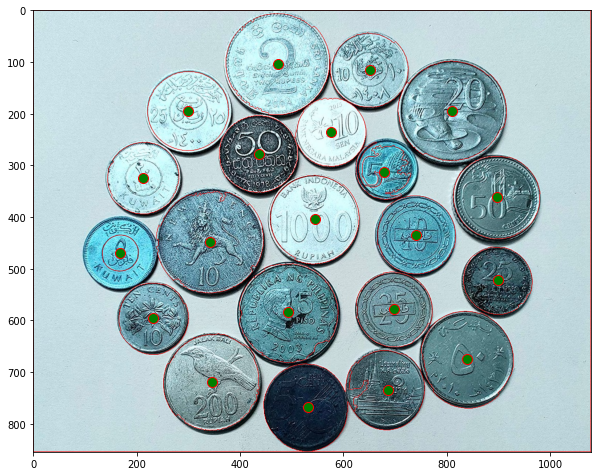

In [22]:
centers = []
X_values = []
y_values = []

for m in np.unique(markers)[2:]:
  masses = np.where(markers==m, 1, 0)
  
  # algorithm to find mass center
  center = ndimage.measurements.center_of_mass(masses)
  centers.append(center)
  X_values.append(center[1])
  y_values.append(center[0])

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.plot(X_values, y_values, "o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.show()

# Result

In [23]:
# loop over the unique labels returned by the Watershed algorithm and visualization

visualization = img.copy()
for label, x, y in zip(np.unique(markers)[2:], X_values, y_values):
	mask = np.zeros(gray_image.shape, dtype="uint8")
	mask[markers == label] = 255
	cv2.putText(visualization, "#{}".format(label-1), (int(x) - 10, int(y)),
	cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

(-0.5, 1079.5, 854.5, -0.5)

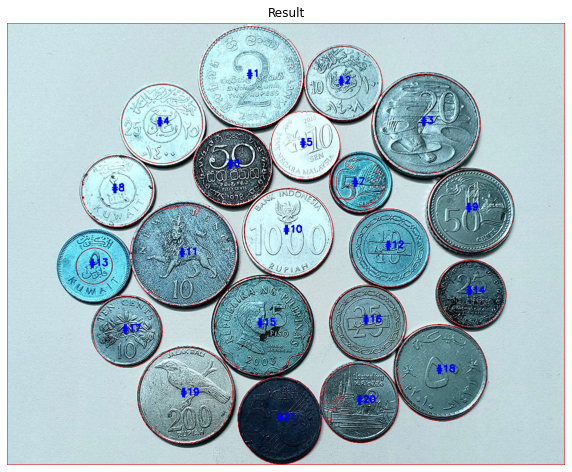

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(visualization)
plt.title('Result')
plt.axis('off')